# 8. Binary classificator
Planes vs Drones

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil #kopiowanie plikow
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

In [2]:
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

--2020-06-07 12:11:28--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   117MB/s    in 14s     

2020-06-07 12:11:43 (105 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [0]:
!rm -rf ./images

In [4]:

base_dir = './data/planes' #katalog bazowy
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes: #w nazwach klas
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))#liczba plikow w katalogu

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
data_dir = './images'

if not os.path.exists(data_dir): #jesli nie istnieje to utwarzamy
    os.mkdir(data_dir)

#laczymy nazwe images + train
train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

#kolejny poziom folderu
train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')


#to samo w pętlach
for directory in (train_dir, valid_dir, test_dir): #przechodzimy dla innych folderow
    if not os.path.exists(directory):
        print(directory)
        os.mkdir(directory)
      
#slash zapisujemy jako _, dir to folder?
dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        print(dir)
        os.mkdir(dir)

./images/train
./images/valid
./images/test
./images/train/drone
./images/train/passenger
./images/valid/drone
./images/valid/passenger
./images/test/drone
./images/test/passenger


In [0]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone')) #nazwy plikow listujemy
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

#proces walidacji, tylko te pliki ze zdjeciami
#bierzemy nazwe pliku i dla kazdej z nich zwraccamy jesli jest spelniony warunek, 
#lower to kazda duza litera na mała, jesli zawiera jpg png itd to wrzucamy do listy
drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [0]:
size = min(len(drone_fnames), len(passenger_fnames)) #rozmiary zbiorow

train_size = int(np.floor(0.7 * size)) #70 % zdjeć
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [9]:
for i, fname in enumerate(drone_fnames): #kopiujemy zdjecia dronow  # zwraca indeks i nazwe
    #print("i : {} , fname {}, enmurate{}".format(i,fname,enumerate(drone_fnames)))
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst) #kopiujemy ze zrodla do zbioru docelowego 
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

i : 0 , fname 00000145.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 1 , fname 00000181.jpg, enmurate<enumerate object at 0x7f9503f969d8>
i : 2 , fname 00001240.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 3 , fname 00000572.jpg, enmurate<enumerate object at 0x7f9503f969d8>
i : 4 , fname 00000629.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 5 , fname 00000276.jpg, enmurate<enumerate object at 0x7f9503f969d8>
i : 6 , fname 00000330.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 7 , fname 00000253.png, enmurate<enumerate object at 0x7f9503f969d8>
i : 8 , fname 00000625.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 9 , fname 00000981.jpg, enmurate<enumerate object at 0x7f9503f969d8>
i : 10 , fname 00001371.jpg, enmurate<enumerate object at 0x7f9503f96948>
i : 11 , fname 00000192.jpg, enmurate<enumerate object at 0x7f9503f969d8>
i : 12 , fname 00000437.jpeg, enmurate<enumerate object at 0x7f9503f96948>
i : 13 , fname 00001328.jpg, enmurate<enumerate

### Data preprocessing completed.

names mapping:   00000538.jpg
{0: '00000145.jpg', 1: '00000181.jpg', 2: '00001240.jpg', 3: '00000572.jpg', 4: '00000629.jpg', 5: '00000276.jpg', 6: '00000330.jpg', 7: '00000253.png', 8: '00000625.jpg', 9: '00000981.jpg', 10: '00001371.jpg', 11: '00000192.jpg', 12: '00000437.jpeg', 13: '00001328.jpg', 14: '00001129.jpg', 15: '00000535.jpg', 16: '00001426.jpg', 17: '00000413.png', 18: '00001153.jpg', 19: '00000349.jpg', 20: '00000571.jpg', 21: '00000605.jpg', 22: '00001427.jpg', 23: '00000790.jpg', 24: '00000525.png', 25: '00000239.jpg', 26: '00000668.jpg', 27: '00000758.jpg', 28: '00001032.jpg', 29: '00000368.jpg', 30: '00000863.jpg', 31: '00000444.jpg', 32: '00000005.jpg', 33: '00000052.jpg', 34: '00001085.jpg', 35: '00000446.jpg', 36: '00000867.jpg', 37: '00000026.png', 38: '00000744.jpg', 39: '00000103.jpg', 40: '00001356.jpg', 41: '00000237.jpg', 42: '00001315.png', 43: '00001359.jpg', 44: '00000924.jpg', 45: '00000447.jpg', 46: '00000802.jpg', 47: '00000135.png', 48: '00001391.jpg'

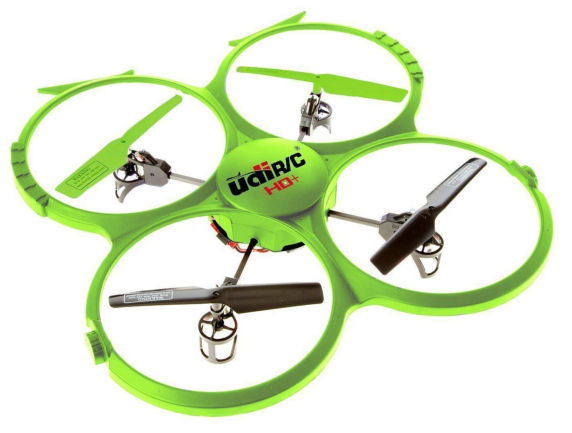

In [14]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 159 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
print("names mapping:   {}".format(names_mapping[idx]))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
print(dict(enumerate(drone_fnames)))

##Zaczynamy agumentacje danych czyli przemienianie

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)


train_generator = train_datagen.flow_from_directory(directory=train_dir,#pokazujemy ile jest klas na podstawie katalogu
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary') #binarny problem

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [0]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

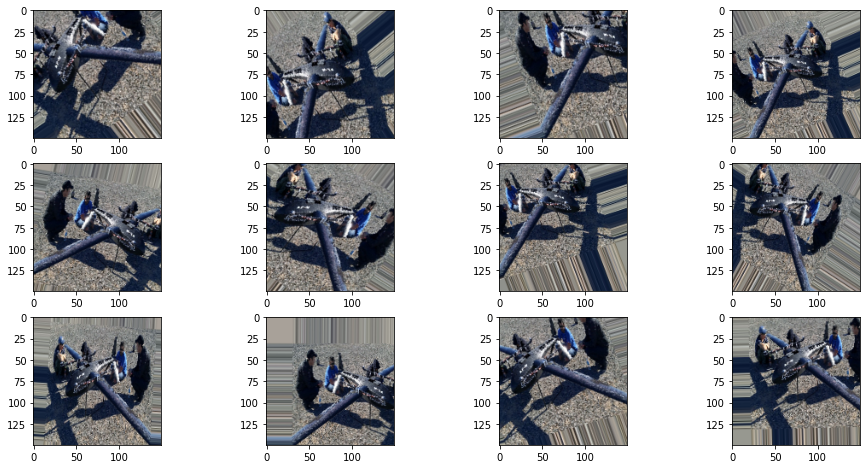

In [18]:

#@title Zbiór treningowy drone:
idx = 100             
display_augmented_images(train_drone_dir, idx)

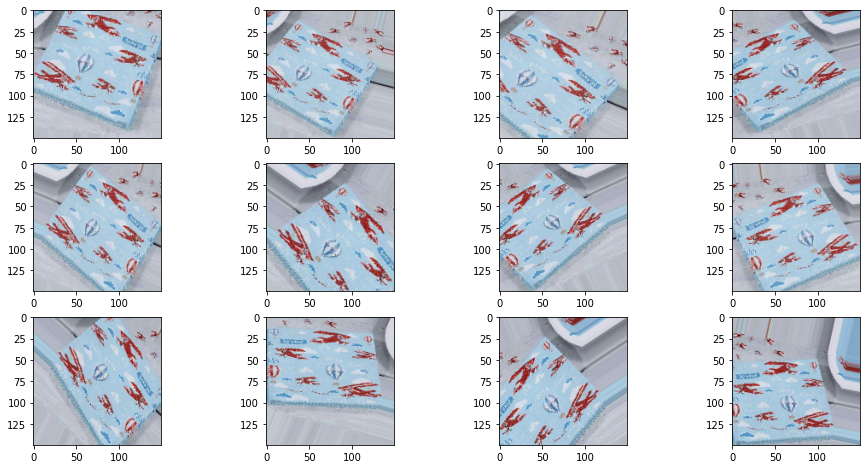

In [20]:
idx = 717
display_augmented_images(train_passenger_dir, idx)

## Setting up a model


In [21]:
model = Sequential()
#filtry i redukcja zdjeć , rozmiar filtru, imput rozmiar danych wejsciowych oraz 3 kolory
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
#okienko lata po okranie i wyciaga max
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#kolejne filtry
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# obrazy 150 na 150 powyzej 
model.add(layers.Flatten()) #wyplaszczenie do wektora
model.add(layers.Dense(units=512, activation='relu')) 
model.add(layers.Dense(units=1, activation='sigmoid')) # model binarny wiec 1 neuron
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:

!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [24]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

#pozwala nam dopasowac generator
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
28/28 [==============================] - 26s 912ms/step - loss: 0.6949 - accuracy: 0.5223 - val_loss: 0.6895 - val_accuracy: 0.5703
Epoch 2/30
28/28 [==============================] - 26s 935ms/step - loss: 0.6937 - accuracy: 0.5330 - val_loss: 0.6877 - val_accuracy: 0.5625
Epoch 3/30
28/28 [==============================] - 27s 963ms/step - loss: 0.6916 - accuracy: 0.5296 - val_loss: 0.6865 - val_accuracy: 0.5078
Epoch 4/30
28/28 [==============================] - 28s 988ms/step - loss: 0.6876 - accuracy: 0.5491 - val_loss: 0.6658 - val_accuracy: 0.5898
Epoch 5/30
28/28 [==============================] - 26s 938ms/step - loss: 0.6831 - accuracy: 0.5569 - val_loss: 0.6896 - val_accuracy: 0.5156
Epoch 6/30
28/28 [==============================] - 27s 973ms/step - loss: 0.6857 - accuracy: 0.5413 - val_loss: 0.6548 - val_accuracy: 0.6602
Epoch 7/30
28/28 [==============================] - 25s 897ms/step

In [0]:

%load_ext tensorboard

In [26]:
!tensorboard dev upload --logdir logs # wchodzisz pod link i logujesz sie dostajesz kod

2020-06-07 13:12:22.938339: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scop

In [27]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

## Stwórzmy teraz nieco lepszy model 
## transfer learning


In [28]:

from tensorflow.keras.applications import VGG16 # w zakladzce applications mamy rozne architerktury na stronie

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [29]:

model = Sequential() #buduejmy instancje modelu 
model.add(conv_base) # jaka pierwsza warstwe dodajemy cala architekture
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [30]:
#chcemy trenowac tylko nowe parametry, czyli chcemy zamrozic model pobrany
print(f'Liczba warstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')

Liczba warstw trenowanych przed zamrożeniem 30
Liczba warstw trenowanych po zamrożeniu 4


In [0]:

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [32]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/50
28/28 [==============================] - 26s 924ms/step - loss: 0.6867 - accuracy: 0.6094 - val_loss: 0.5717 - val_accuracy: 0.6719
Epoch 2/50
28/28 [==============================] - 26s 911ms/step - loss: 0.5669 - accuracy: 0.7039 - val_loss: 0.4601 - val_accuracy: 0.7773
Epoch 3/50
28/28 [==============================] - 27s 948ms/step - loss: 0.5364 - accuracy: 0.7244 - val_loss: 0.5674 - val_accuracy: 0.6875
Epoch 4/50
28/28 [==============================] - 27s 981ms/step - loss: 0.5227 - accuracy: 0.7277 - val_loss: 0.4261 - val_accuracy: 0.7930
Epoch 5/50
28/28 [==============================] - 28s 1s/step - loss: 0.4931 - accuracy: 0.7517 - val_loss: 0.5405 - val_accuracy: 0.7070
Epoch 6/50
28/28 [==============================] - 28s 993ms/step - loss: 0.4739 - accuracy: 0.7768 - val_loss: 0.4255 - val_accuracy: 0.7773
Epoch 7/50
 8/28 [=======>......................] - ETA: 15s - loss: 0.4826 - accuracy: 0.7461

KeyboardInterrupt: ignored

In [33]:

import plotly.graph_objects as go
plot_hist(history)

In [34]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True #odmrazamy

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_2       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [35]:
set_trainable = False
for layer in conv_base.layers: #od pewnej warstwy odmrazamy
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_2       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [36]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/30
28/28 [==============================] - 27s 977ms/step - loss: 0.6720 - accuracy: 0.5871 - val_loss: 0.5840 - val_accuracy: 0.7109
Epoch 2/30
28/28 [==============================] - 26s 926ms/step - loss: 0.5847 - accuracy: 0.6853 - val_loss: 0.4847 - val_accuracy: 0.7695
Epoch 3/30
28/28 [==============================] - 30s 1s/step - loss: 0.5296 - accuracy: 0.7366 - val_loss: 0.4377 - val_accuracy: 0.7930
Epoch 4/30
28/28 [==============================] - 28s 1s/step - loss: 0.5039 - accuracy: 0.7522 - val_loss: 0.4404 - val_accuracy: 0.7734
Epoch 5/30
28/28 [==============================] - 26s 928ms/step - loss: 0.4587 - accuracy: 0.7768 - val_loss: 0.4142 - val_accuracy: 0.7891
Epoch 6/30
28/28 [==============================] - 28s 989ms/step - loss: 0.4521 - accuracy: 0.7757 - val_loss: 0.4317 - val_accuracy: 0.7656
Epoch 7/30
28/28 [==============================] - 30s 1s/step - loss: 0.4310 - accuracy: 0.7882 - val_loss: 0.4031 - val_accuracy: 0.8047
Epoch 8/

KeyboardInterrupt: ignored

In [38]:
plot_hist(history)

## ocena na zbiorze testowym

In [39]:

test_datagen = ImageDataGenerator(rescale=1./255.) #tylko ten parametr mozemy zmieniac
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob #prawdopodobienstwa przynaleznosci do pewnej klasy

Found 262 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


array([0.121154, 0.012298, 0.278808, 0.024801, 0.011633, 0.003749,
       0.00487 , 0.006695, 0.013813, 0.000909, 0.081823, 0.016629,
       0.13143 , 0.121024, 0.103174, 0.229294, 0.098914, 0.001695,
       0.045748, 0.227429, 0.001638, 0.002541, 0.02985 , 0.274997,
       0.008862, 0.128747, 0.392087, 0.012197, 0.706999, 0.282521,
       0.325186, 0.004015, 0.124764, 0.009553, 0.30198 , 0.062016,
       0.189143, 0.713973, 0.079121, 0.481211, 0.198551, 0.077863,
       0.062654, 0.413141, 0.528224, 0.008864, 0.009018, 0.075728,
       0.010128, 0.349255, 0.020421, 0.233834, 0.033655, 0.305134,
       0.019804, 0.197177, 0.585157, 0.310518, 0.17279 , 0.034599,
       0.013926, 0.045847, 0.027006, 0.024747, 0.530636, 0.004684,
       0.005512, 0.009895, 0.12442 , 0.182415, 0.008857, 0.091043,
       0.386327, 0.268485, 0.157825, 0.01646 , 0.106654, 0.480142,
       0.047763, 0.031164, 0.035479, 0.178465, 0.269932, 0.35451 ,
       0.023815, 0.530864, 0.391405, 0.235916, 0.248932, 0.490

In [40]:

predictions  = pd.DataFrame({'y_prob': y_prob})#1 gdy wieksze od 1/2 a 0 w przeciwnwym
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.121154,0
1,0.012298,0
2,0.278808,0
3,0.024801,0
4,0.011633,0
...,...,...
257,0.974274,1
258,0.586702,1
259,0.771323,1
260,0.938903,1


In [41]:

y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [44]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [45]:

test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [46]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[114,  17],
       [ 18, 113]])

In [47]:

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       131
           1       0.87      0.86      0.87       131

    accuracy                           0.87       262
   macro avg       0.87      0.87      0.87       262
weighted avg       0.87      0.87      0.87       262



## wyswietlanie blednych predykcji

In [48]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head() # 5 pierwszych wierszy

,y_true,y_pred
drone/00000001.jpg,0,0
drone/00000017.jpg,0,0
drone/00000023.jpg,0,0
drone/00000025.jpg,0,0
drone/00000028.jpg,0,0


In [49]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000001.jpg,0,0,0
drone/00000017.jpg,0,0,0
drone/00000023.jpg,0,0,0
drone/00000025.jpg,0,0,0
drone/00000028.jpg,0,0,0
...,...,...,...
passenger/00001436.jpg,1,1,0
passenger/00001439.jpg,1,1,0
passenger/00001448.jpg,1,1,0
passenger/00001455.jpg,1,1,0


In [50]:
errors[errors['is_incorrect'] == 1].index #wypisujemy te ktore sa zle przwidziane

Index(['drone/00000258.jpg', 'drone/00000373.jpg', 'drone/00000417.jpg',
       'drone/00000510.png', 'drone/00000593.jpg', 'drone/00000787.png',
       'drone/00000847.jpg', 'drone/00000882.jpeg', 'drone/00000951.jpg',
       'drone/00000957.jpg', 'drone/00000973.jpg', 'drone/00001024.jpg',
       'drone/00001033.jpg', 'drone/00001060.jpg', 'drone/00001213.jpg',
       'drone/00001266.png', 'drone/00001318.jpg', 'passenger/00000137.jpg',
       'passenger/00000154.jpg', 'passenger/00000171.jpg',
       'passenger/00000182.jpg', 'passenger/00000203.jpeg',
       'passenger/00000291.png', 'passenger/00000436.jpg',
       'passenger/00000498.jpg', 'passenger/00000544.jpg',
       'passenger/00000585.jpg', 'passenger/00000631.jpg',
       'passenger/00000642.jpg', 'passenger/00000695.jpg',
       'passenger/00000751.jpg', 'passenger/00000773.jpg',
       'passenger/00000785.jpg', 'passenger/00001304.jpg',
       'passenger/00001404.JPG'],
      dtype='object')

(-0.5, 620.5, 413.5, -0.5)

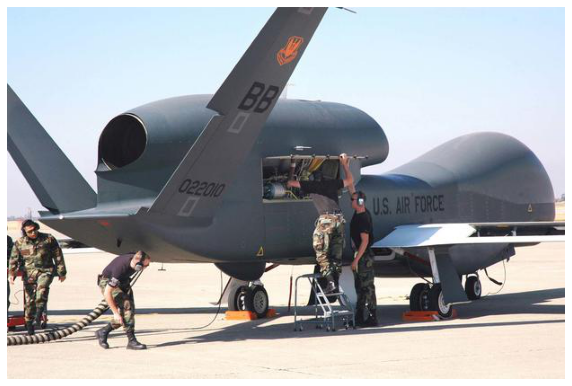

In [55]:

img_path = os.path.join(test_drone_dir, '00001404.jpg') # co nie poprowanie sklasyfikowane

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [56]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000258.jpg', 'drone/00000373.jpg', 'drone/00000417.jpg',
       'drone/00000510.png', 'drone/00000593.jpg', 'drone/00000787.png',
       'drone/00000847.jpg', 'drone/00000882.jpeg', 'drone/00000951.jpg',
       'drone/00000957.jpg', 'drone/00000973.jpg', 'drone/00001024.jpg',
       'drone/00001033.jpg', 'drone/00001060.jpg', 'drone/00001213.jpg',
       'drone/00001266.png', 'drone/00001318.jpg', 'passenger/00000137.jpg',
       'passenger/00000154.jpg', 'passenger/00000171.jpg',
       'passenger/00000182.jpg', 'passenger/00000203.jpeg',
       'passenger/00000291.png', 'passenger/00000436.jpg',
       'passenger/00000498.jpg', 'passenger/00000544.jpg',
       'passenger/00000585.jpg', 'passenger/00000631.jpg',
       'passenger/00000642.jpg', 'passenger/00000695.jpg',
       'passenger/00000751.jpg', 'passenger/00000773.jpg',
       'passenger/00000785.jpg', 'passenger/00001304.jpg',
       'passenger/00001404.JPG'],
      dtype='object')

(-0.5, 449.5, 271.5, -0.5)

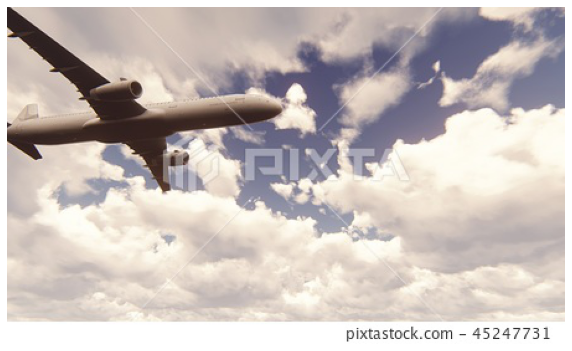

In [59]:

img_path = os.path.join(test_passenger_dir, '00001304.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)